In [1]:
import pandas as pd

In [2]:
# read notevents data
noteevents_df = pd.read_csv('NOTEEVENTS.csv')

C:\Users\yherw\AppData\Local\Temp\ipykernel_23784\2311210665.py:2: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  noteevents_df = pd.read_csv('NOTEEVENTS.csv')


In [3]:
noteevents_df.shape

(2083180, 11)

In [4]:
noteevents_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,174,22532,167853.0,2151-08-04,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2151-7-16**] Dischar...
1,175,13702,107527.0,2118-06-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2118-6-2**] Discharg...
2,176,13702,167118.0,2119-05-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2119-5-4**] D...
3,177,13702,196489.0,2124-08-18,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2124-7-21**] ...
4,178,26880,135453.0,2162-03-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2162-3-3**] D...


In [5]:
noteevents_df['CATEGORY'].value_counts()

CATEGORY
Nursing/other        822497
Radiology            522279
Nursing              223556
ECG                  209051
Physician            141624
Discharge summary     59652
Echo                  45794
Respiratory           31739
Nutrition              9418
General                8301
Rehab Services         5431
Social Work            2670
Case Management         967
Pharmacy                103
Consult                  98
Name: count, dtype: int64

In [6]:
# read diagnoses data
diagnoses_df = pd.read_csv('DIAGNOSES_ICD.csv')

In [7]:
diagnoses_df.shape

(651047, 5)

In [8]:
diagnoses_df['ICD9_CODE'].value_counts()

ICD9_CODE
4019     20703
4280     13111
42731    12891
41401    12429
5849      9119
         ...  
1270         1
E9659        1
71926        1
9593         1
20930        1
Name: count, Length: 6984, dtype: int64

In [9]:
# Extract notes for hypertension related diagnoses (following ICD9-codes: '4010', '4011', '40591', '40599', '4160')
# ICD9_code '4019' is excluded to reduce the dataset 
arr_subject_id=[]
arr_hadm_id=[]
arr_icd9_code=[]
for row in range(0, len(diagnoses_df)):
  if(diagnoses_df.loc[row, 'ICD9_CODE'] in ['4010', '4011', '40591', '40599', '4160']):
    arr_subject_id.append(diagnoses_df.loc[row, 'SUBJECT_ID'])
    arr_hadm_id.append(diagnoses_df.loc[row, 'HADM_ID'])
    arr_icd9_code.append(diagnoses_df.loc[row, 'ICD9_CODE'])

In [10]:
print('length of array is:',len(arr_subject_id))

length of array is: 1051


## Filter Noteevents for Hypertension related diagnoses

In [11]:
icd9_patients_discharge_summary_df = pd.DataFrame(columns=['SUBJECT_ID', 'CATEGORY', 'TEXT',"ICD_9_CODE"])
patients_dict = {"SUBJECT_ID":[],"CATEGORY":[],"TEXT":[],"ICD_9_CODE":[]}

In [12]:
for i in range(0, len(noteevents_df)):
  if((noteevents_df.loc[i, 'SUBJECT_ID'] in arr_subject_id) and (noteevents_df.loc[i, 'HADM_ID'] in arr_hadm_id)  and (noteevents_df.loc[i, 'CATEGORY'] == 'Discharge summary')):
   patients_dict["SUBJECT_ID"].append(noteevents_df.loc[i, 'SUBJECT_ID'])
   patients_dict["CATEGORY"].append(noteevents_df.loc[i, 'CATEGORY'])
   patients_dict["TEXT"].append(noteevents_df.loc[i, 'TEXT'])
   patients_dict["ICD_9_CODE"].append(diagnoses_df.loc[(diagnoses_df['SUBJECT_ID'] == noteevents_df.loc[i, 'SUBJECT_ID']) & (diagnoses_df['HADM_ID'] == noteevents_df.loc[i, 'HADM_ID']), 'ICD9_CODE'].values[0])

In [14]:
patients_df = pd.DataFrame(patients_dict)

In [15]:
patients_df.to_csv("Icd9codes_discharge_summary.csv")

In [16]:
patients_df.shape

(1159, 4)

In [17]:
patients_df.to_excel("ICD9_Patients_DischargeSummary.xlsx")

In [18]:
import spacy
nlp = spacy.load('en_core_web_sm')

C:\ProgramData\anaconda3\Lib\site-packages\spacy\util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.8.0) was trained with spaCy v3.8.0 and may not be 100% compatible with the current version (3.7.5). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [19]:
doc = []
for row in patients_df.itertuples():
  doc.append(nlp(row.TEXT))

In [ ]:
# Entity Visualizer
from spacy import displacy
for i in range(len(doc)):
  displacy.render(doc[i], style="ent", jupyter=True)
  print('*********************************************************************************************************************************************************************')

In [ ]:
# Install en_ner_bc5cdr_md model
#!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_ner_bc5cdr_md-0.5.4.tar.gz

In [21]:
import scispacy
import en_ner_bc5cdr_md
nlp = en_ner_bc5cdr_md.load()
doc = []
for row in patients_df.itertuples():
  doc.append(nlp(row.TEXT))
  

C:\ProgramData\anaconda3\Lib\site-packages\spacy\language.py:2195: FutureWarning: Possible set union at position 6328
  deserializers["tokenizer"] = lambda p: self.tokenizer.from_disk(  # type: ignore[union-attr]


In [ ]:
for i in range(len(doc)):
  displacy.render(doc[i], style="ent", jupyter=True)
  print('***************************************************************************')

In [2]:
import gensim
import gensim.downloader as api

info = api.info()  # show info about available models/datasets
pretrained_model= api.load("glove-wiki-gigaword-50")  # download the model and return as object ready for use

In [3]:
pretrained_model.most_similar("hypertension")

[('diabetes', 0.8793396353721619),
 ('pulmonary', 0.8310757875442505),
 ('cardiovascular', 0.8051982522010803),
 ('asthma', 0.7974347472190857),
 ('chronic', 0.7766041159629822),
 ('atherosclerosis', 0.7635468244552612),
 ('respiratory', 0.7634569406509399),
 ('mellitus', 0.7545502185821533),
 ('hemophilia', 0.7536296844482422),
 ('glaucoma', 0.7512805461883545)]

In [4]:
import pandas as pd
patients_df = pd.read_csv('Icd9codes_discharge_summary.csv')

In [3]:
patients_df.head()

,Unnamed: 0,SUBJECT_ID,CATEGORY,TEXT,ICD_9_CODE
0,0,13702,Discharge summary,Admission Date: [**2124-7-21**] ...,51884
1,1,26880,Discharge summary,Admission Date: [**2162-3-3**] D...,80506
2,2,1136,Discharge summary,Admission Date: [**2194-8-15**] ...,42830
3,3,22180,Discharge summary,Admission Date: [**2134-2-16**] ...,80600
4,4,22180,Discharge summary,Admission Date: [**2134-8-12**] ...,51881


In [49]:
import scispacy
import spacy

nlp = spacy.load("en_ner_bc5cdr_md")

In [51]:
# Build corpus of all the entities extracted from the notes using spaCy model.
# The corpus is an array of arrays or list of lists where each of the nested lists corresponds to a note.
# change token to lowercase
corpus=[]

for row in patients_df.itertuples():
  str_tokens=[]
  tokens= nlp(row.TEXT).ents
  for i in range(0, len(tokens)):
    str_tokens.append(tokens[i].text.lower())
  corpus.append(list(str_tokens))

In [7]:
import gensim
import gensim.downloader as api

info = api.info()  # show info about available models/datasets
pretrained_model= api.load("glove-wiki-gigaword-50")  # download the model and return as object ready for use

In [53]:
from gensim.models import word2vec
import numpy as np

model = word2vec.Word2Vec(corpus, min_count=1)
vocabs = model.wv.index_to_key  # Access vocabulary using index_to_key
new_v = np.array(list(vocabs))

In [54]:
new_corpus_in_pretrained_model = []
for word in new_v:
    if word in pretrained_model.key_to_index:
        new_corpus_in_pretrained_model.append(word)
    else:
        print(word)  # Print out-of-vocabulary words

chest pain
htn
shortness of breath
q.d
tablet(s
q6h
atrial fibrillation
abdominal pain
mitral regurgitation
pleural effusion
pericardial effusion
pulmonary hypertension
coronary artery disease
pleural effusions
metoprolol tartrate
labetalol
q4h
congestive heart failure
qhs
pulmonary edema
qid
aortic stenosis
q8h
aortic regurgitation
diabetes mellitus
flagyl
heart failure
q12h
acute renal failure
lopressor
ventricular hypertrophy
cardiomegaly
organomegaly
dysuria
albuterol sulfate
ctab
respiratory distress
pulmonary embolism
hctz
respiratory failure
orthopnea
myocardial infarction
tricuspid regurgitation
name9
folic acid
levophed
cefepime
potassium chloride
gi bleed
milrinone
ck-mb-notdone
metoprolol succinate
ipratropium bromide
glyburide
pulmonary artery systolic hypertension
weight loss
nstemi
nausea,
glipizide
myalgias
fio2
shortness of
breath
glargine
t.i.d
sinus tachycardia
keppra
calcium carbonate
adverse drug reactions
vitamin d
renal failure
ferrous sulfate
alcohol abuse
aortic

In [58]:
def tsne_plot(model, words):
    "Creates a t-SNE model and plots it"
    labels = []
    tokens = []

    for word in words:
        if word in model:
            tokens.append(model[word])
            labels.append(word)
        else:
            print(f"Skipping '{word}' as it is not present in the model's vocabulary.")

    tsne_model = TSNE(perplexity=50, early_exaggeration=12, n_components=2, init='pca', n_iter=1000, random_state=23)
    new_values = tsne_model.fit_transform(np.array(tokens))  # Convert tokens to a NumPy array

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(70, 70))
    for i in range(len(x)):
        plt.scatter(x[i], y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

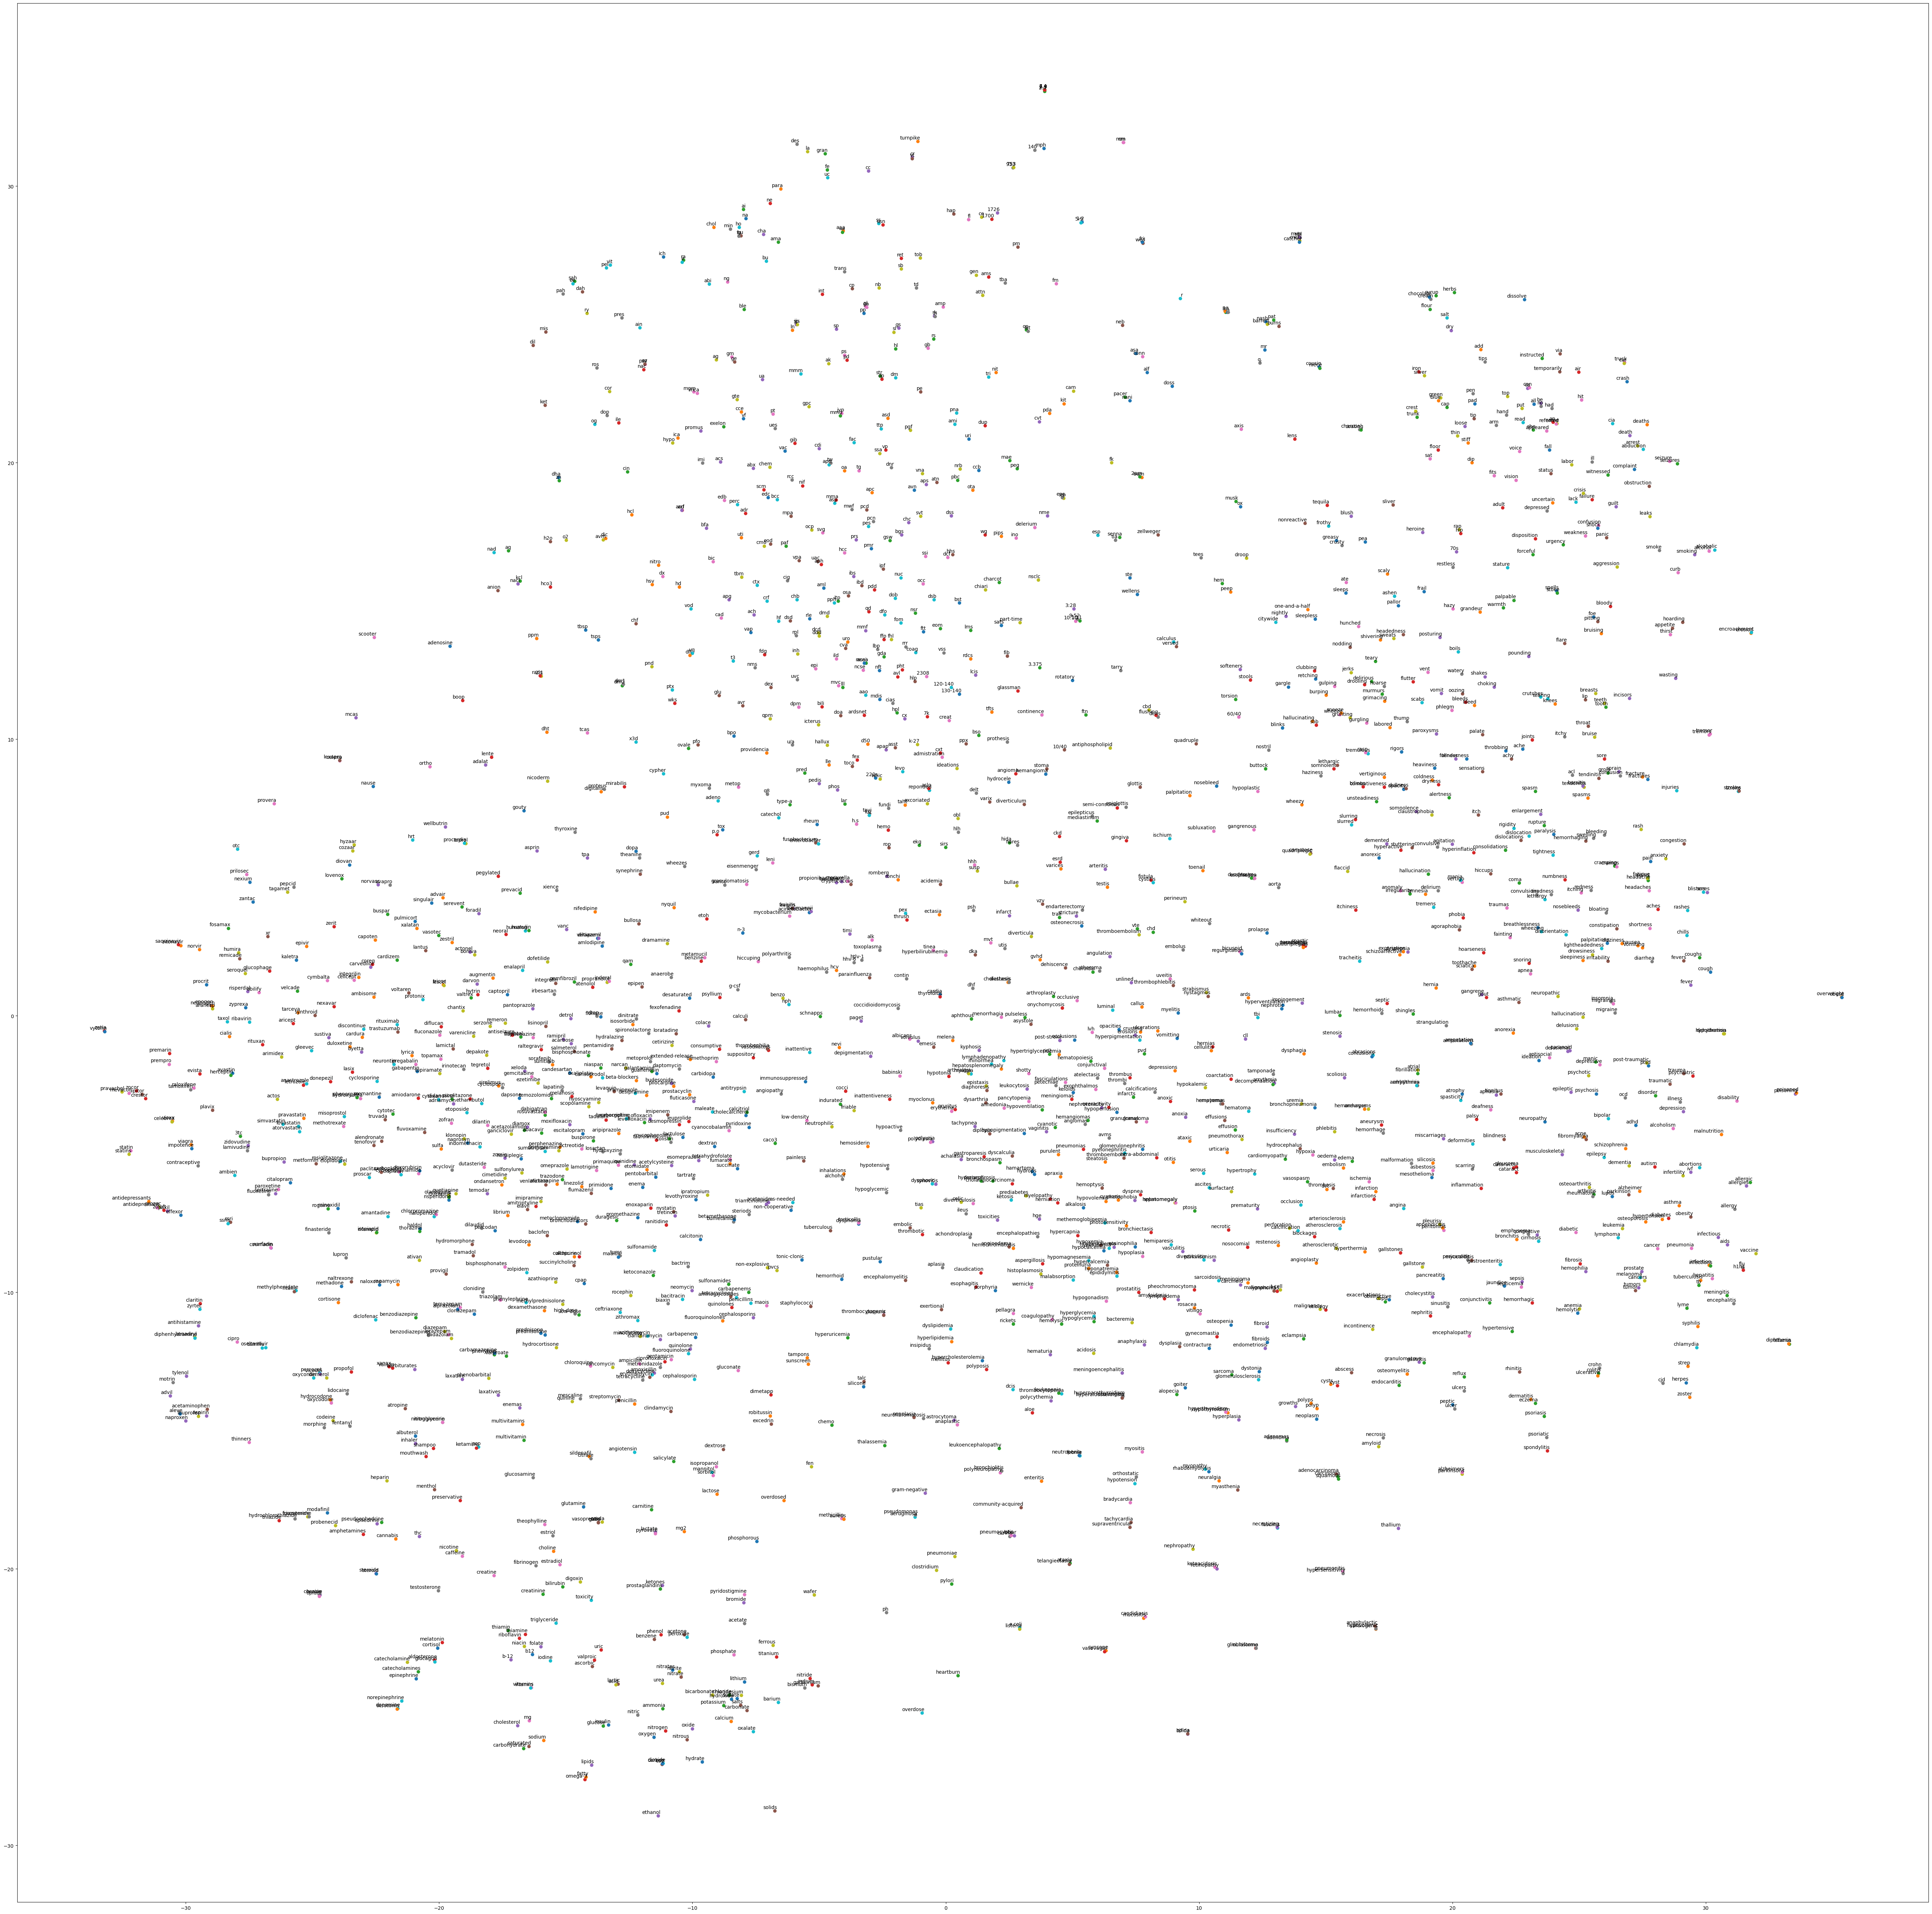

In [59]:
# commented out to reduce
# tsne_plot(pretrained_model,new_corpus_in_pretrained_model)

In [60]:
print(spacy.__version__)

3.7.5


In [61]:
print(scispacy.__version__)

0.5.5


## Clinical BERT

In [1]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yherw\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yherw\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yherw\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
def clean_text(text):
    # Tokenize the text into words
    words = text.split()

    # Remove special characters and convert to lowercase
    clean_words = [word.lower() for word in words if word.isalnum()]

    # Remove stopwords
    stop_words = set(stopwords.words("english"))
    filtered_words = [word for word in clean_words if word not in stop_words]

    # Remove words with less than 4 characters and numbers. This is done in order to reduce noisy data and numbers dont contribute much in any NLP applications
    filtered_words = [word for word in filtered_words if len(word) >= 4 and not word.isdigit()]

    # Remove duplicate words
    cleaned_text = " ".join(dict.fromkeys(filtered_words))  # This is useful while plotting t-SNE plots

    return cleaned_text

In [58]:
import scispacy
import spacy

nlp = spacy.load("en_ner_bc5cdr_md")

corpus=[]

for row in patients_df.itertuples():
  str_tokens=[]
  tokens= nlp(row.TEXT).ents
  for i in range(0, len(tokens)):
    str_tokens.append(tokens[i].text)
  corpus.append(list(str_tokens))

notes_combined = []

# Iterate through the sublists and combine the words
for sublist in corpus:
    notes_combined.extend(sublist)

notes_combined = ' '.join(notes_combined)

In [59]:
# Visualization of notes filtered with SciSpacy using ClinicalBert
import numpy as np
from sklearn.manifold import TSNE
import string
import matplotlib.pyplot as plt
from transformers import AutoModel, AutoTokenizer
import torch

# Load the BERT model and tokenizer
clinical_model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
clinical_tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
clinical_model.eval()

input_text = clean_text(notes_combined)
input_tokens = input_text.split()

# Initialize an empty list to store word embeddings
word_embs = []

for token in input_tokens:
    # Check if the token is a valid word
    if token not in string.punctuation:
        # Encode the token using the BERT model
        inputs = clinical_tokenizer(token, return_tensors="pt")
        with torch.no_grad():
            outputs = clinical_model(**inputs)
        token_emb = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
        word_embs.append(token_emb)

tsne_model = TSNE(perplexity=10, early_exaggeration=12, n_components=2, init='pca', n_iter=1000, random_state=42)
word_embs_2d = tsne_model.fit_transform(np.array(word_embs))

In [60]:
# determine location of hypertension in the word embedding
text_to_check = 'hypertension'
for i in range(len(word_embs_2d)):
    if text_to_check == input_tokens[i]:
        hypertension0 = word_embs_2d[i, 0]
        hypertension1 = word_embs_2d[i, 1]


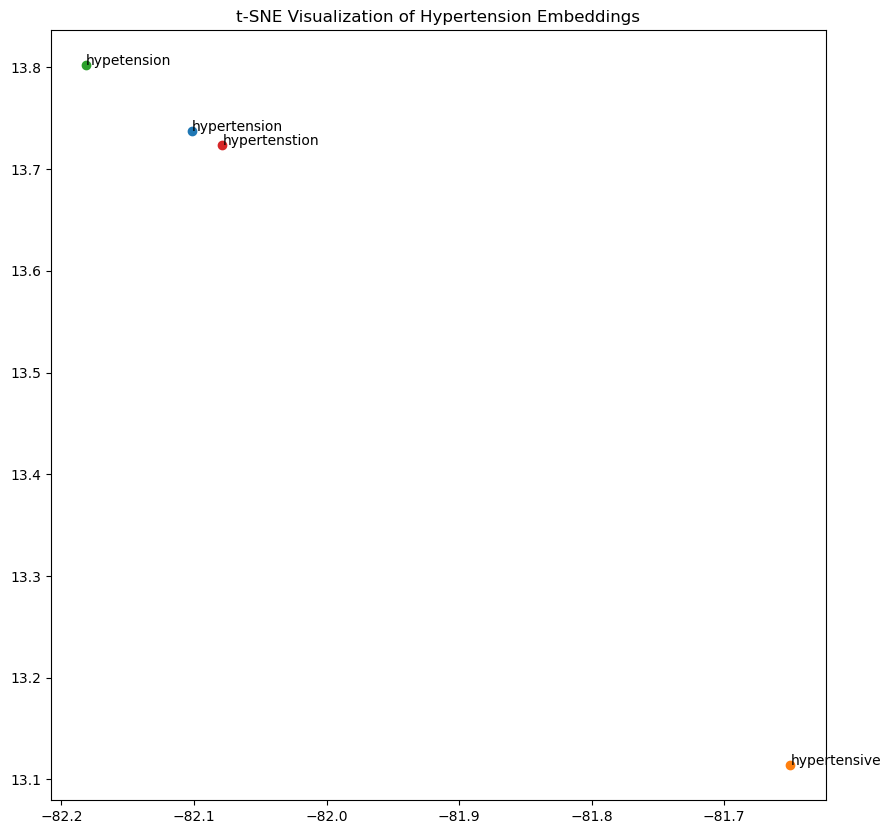

In [62]:
plt.figure(figsize=(10, 10))
dim0_low = hypertension0 - 2.0
dim0_high = hypertension0 + 2.0
dim1_low = hypertension1 - 2.0
dim1_high = hypertension1 + 2.0
  
for i in range(len(word_embs_2d)):
    if ((word_embs_2d[i, 0]>=dim0_low and word_embs_2d[i, 0]<=dim0_high) 
        and (word_embs_2d[i, 1]>=dim1_low and word_embs_2d[i, 1]<=dim1_high)):
        plt.scatter(word_embs_2d[i, 0], word_embs_2d[i, 1])
        plt.annotate(input_tokens[i], (word_embs_2d[i, 0], word_embs_2d[i, 1]))

plt.title("t-SNE Visualization of Hypertension Embeddings")
plt.show()